In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

import matplotlib.patches as patches

In [2]:
H = 40
W = 40
h = H-1
w = W-1

n_min = 2
n_max = 5

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.73818459 0.875      0.10308571 0.10308571]
 [0.33553547 0.625      0.15775416 0.15775416]
 [0.42338477 0.375      0.21544618 0.21544618]
 [0.41373709 0.125      0.144271   0.14871047]]
[2. 1. 1. 0.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = j/(W-1)
        anchors[i,j,:,1] = i/(H-1)
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

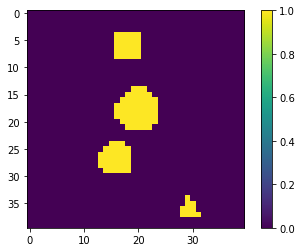

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 10000
lr         = 0.0001
print_step = 1000

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=20, hidden_size=256)

rcnn     = net.RCNN(backbone, rpn, anchors, backbone_channels=1, 
                   window_size=10, hidden_size=256, num_classes=3, obj_threshold=0.8, scope='rcnn')


crop_conv = rcnn(x_tf)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_sum(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = 10*tf.reduce_sum(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

lab_sum = tf.reduce_sum(y_label_tf)

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0815 16:00:04.737293 140121516545792 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0815 16:00:04.739371 140121516545792 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/rcnn/net.py:14: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0815 16:00:04.740604 140121516545792 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0815 16:00:04.871448 140121516545792 deprecation.py:323] From /home/marsdenlab/anaconda3/lib/python3.6/site-packages/tens

Tensor("Sum_1:0", shape=(), dtype=float32) Tensor("mul_7:0", shape=(), dtype=float32) Tensor("add_2:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l,lc,lb,ls = sess.run([loss, loss_class, loss_box, lab_sum], {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f} loss_class={:.3f} loss_box={:.3f}, lab_sum={:.1f}".format(i,l, lc, lb, ls))

iteration 0: loss=4337.894 loss_class=4321.539 loss_box=16.355, lab_sum=17.0
iteration 1000: loss=6.291 loss_class=3.621 loss_box=2.670, lab_sum=16.0
iteration 2000: loss=13.046 loss_class=4.556 loss_box=8.489, lab_sum=27.0
iteration 3000: loss=2.233 loss_class=0.696 loss_box=1.537, lab_sum=25.0
iteration 4000: loss=1.470 loss_class=0.181 loss_box=1.290, lab_sum=17.0
iteration 5000: loss=0.621 loss_class=0.155 loss_box=0.466, lab_sum=20.0
iteration 6000: loss=1.981 loss_class=0.583 loss_box=1.398, lab_sum=13.0
iteration 7000: loss=0.163 loss_class=0.163 loss_box=0.000, lab_sum=0.0
iteration 8000: loss=0.330 loss_class=0.057 loss_box=0.273, lab_sum=22.0
iteration 9000: loss=0.220 loss_class=0.044 loss_box=0.176, lab_sum=8.0


In [10]:
x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)

gt_t, gt_matched, gt_labels, gt_weights =\
box.create_box_gt(anchors_1d, gt_box)

x = x.reshape((1,H,W,1))

out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

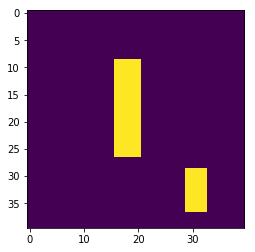

0


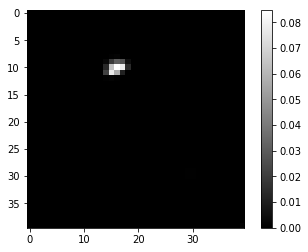

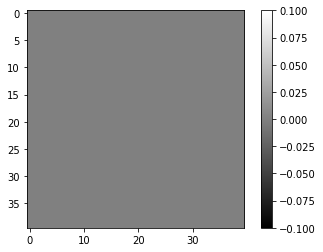

1


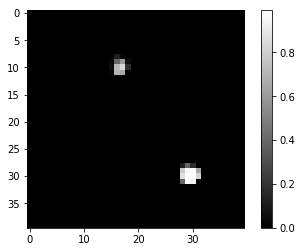

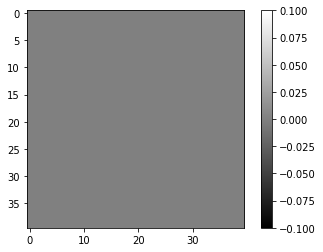

2


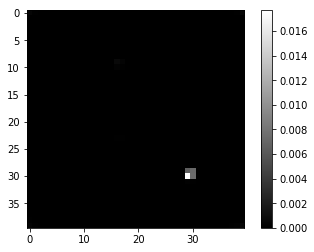

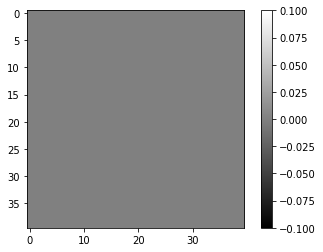

3


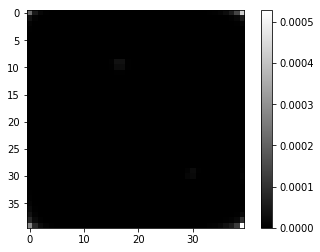

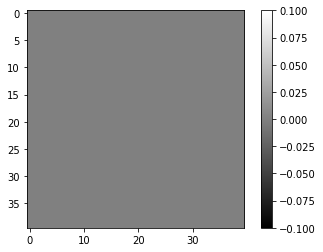

weights
0


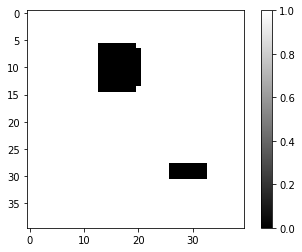

1


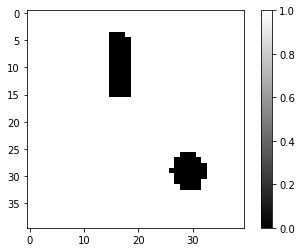

2


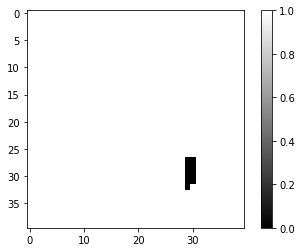

3


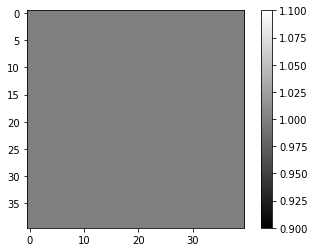

In [11]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [13]:
predicted_boxes, predicted_obj = sess.run([list_box, list_obj],{x_tf:x})

In [14]:
anch_p = anchors.reshape((-1,4))[predicted_obj>0.9]
print(anch_p)

[[0.74358974 0.74358974 0.2        0.2       ]
 [0.76923077 0.74358974 0.2        0.2       ]
 [0.74358974 0.76923077 0.2        0.2       ]
 [0.76923077 0.76923077 0.2        0.2       ]
 [0.74358974 0.79487179 0.2        0.2       ]
 [0.76923077 0.79487179 0.2        0.2       ]]


In [15]:
bp = predicted_boxes[predicted_obj>0.9]
print(bp)

[[ 0.04096427  0.06604725 -0.4483381   0.06187773]
 [-0.06237784  0.04893939 -0.4133094   0.06126195]
 [ 0.03538004 -0.06093797 -0.4651324   0.04938376]
 [-0.07850607 -0.05866447 -0.4329461   0.05929397]
 [ 0.05598391 -0.12805444 -0.46428844 -0.0061766 ]
 [-0.04175119 -0.1086098  -0.43364537 -0.01409827]]


In [16]:
gt_p = gt_t[predicted_obj>0.9]
print(gt_p)

[[ 0.02383432  0.03205128 -0.48598074  0.09668098]
 [-0.1043708   0.03205128 -0.48598074  0.09668098]
 [ 0.02383432 -0.09615385 -0.48598074  0.09668098]
 [-0.1043708  -0.09615385 -0.48598074  0.09668098]
 [ 0.02383432 -0.22435897 -0.48598074  0.09668098]
 [-0.1043708  -0.22435897 -0.48598074  0.09668098]]


In [17]:
bp_n = box.inv_bbox_transform(anch_p, bp)
gt_n = box.inv_bbox_transform(anch_p, gt_p)
print(bp_n*H)
print(gt_n*H)
print(gt_box*H)

[[30.07130389 30.27196775  5.10950947  8.51065826]
 [30.27020805 30.13510488  5.29166079  8.50541878]
 [30.02663003 30.28172703  5.02441549  8.40498734]
 [30.14118217 30.29991503  5.18876362  8.48869705]
 [30.19146104 30.77043627  5.02865791  7.95073938]
 [30.43522124 30.92599337  5.18513632  7.88800526]]
[[29.93426434 30.          4.92074925  8.81207134]
 [29.93426434 30.          4.92074925  8.81207134]
 [29.93426434 30.          4.92074925  8.81207134]
 [29.93426434 30.          4.92074925  8.81207134]
 [29.93426434 30.          4.92074925  8.81207134]
 [29.93426434 30.          4.92074925  8.81207134]]
[[29.93426434 30.          4.92074925  8.81207134]
 [16.6154907  10.          5.23230766 18.1513771 ]]


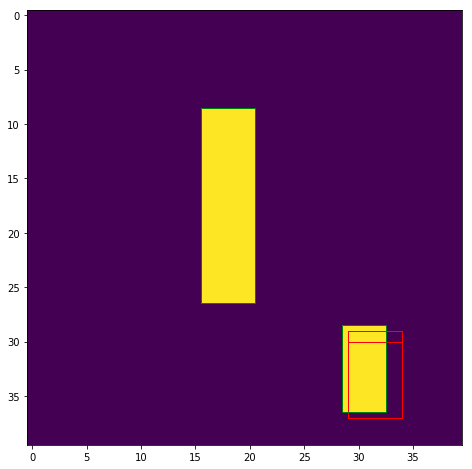

In [18]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(8,8))

# Display the image
ax.imshow(x[0,:,:,0])

# Create a Rectangle patch
for b in bp_n:
    rect = patches.Rectangle((int(b[0]*w),int(b[1]*h)),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Create a Rectangle patch
for b in gt_box:
    rect = patches.Rectangle((int(b[0]*w)-0.5,int(b[1]*h)-0.5),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

In [19]:
cropped = sess.run(crop_conv,{x_tf:x})

In [20]:
print(cropped.shape)

(9, 30, 30, 1)


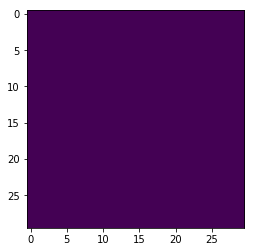

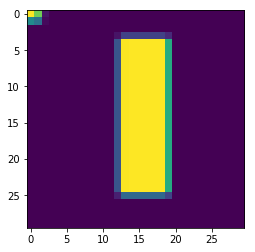

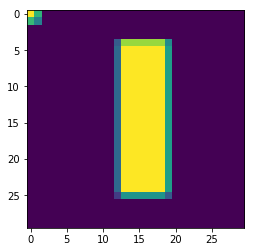

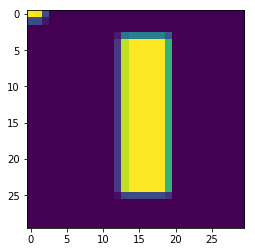

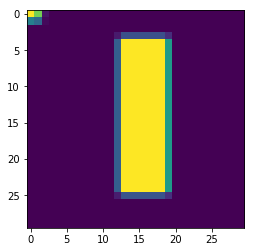

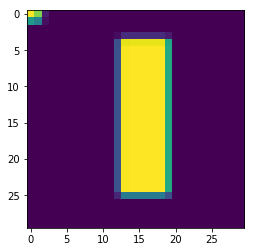

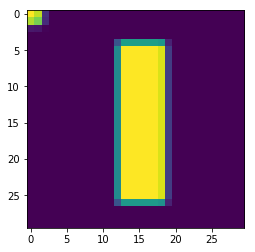

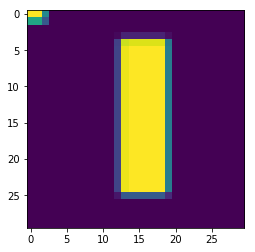

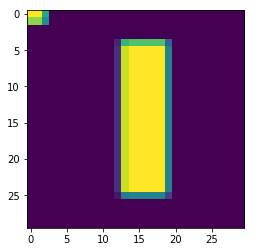

In [21]:
for n in range(cropped.shape[0]):
    plt.figure()
    plt.imshow(cropped[n,:,:,0])
    plt.show()